## Differences with original model
Ive made these changes to our original model because the result did not make sense/ data did not exist.

- tau is seperate for input and export of power
- cost of PV power is always 0 (data did not exist)
- changed PV allocation constraint ( it should not include g_exp because g_exp > Pt_PV is allowed)
- changed "+ ct_PV \*st[t]" to "+ ct_PV\*Pt_PV[t] " in objective function, if we curtail PV production we areutill paying for it? (has no effect because cost is zero anyways)

In [5]:
 #pip install gurobipy

In [6]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import json



# Data Inputs (& flexibility param)


In [7]:
# Run this once to open JSONs (all files from /task1/data)

import json
import csv
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# load JSONs
with open('../data/question_1a/bus_params.json', 'r') as file:
    bus_params = json.load(file)
#print(json.dumps(bus_params, indent=4))
with open('../data/question_1a/DER_production.json', 'r') as file:
    der_production = json.load(file)
#print(json.dumps(der_production, indent=4))

with open('../data/question_1a/appliance_params.json', 'r') as file:
    appl_params= json.load(file)
#print(json.dumps(appl_params, indent=4))

with open('../data/question_1a/usage_preference.json', 'r') as file:
    usage_preference= json.load(file)
#print(json.dumps(usage_preference, indent=4))


# Read relevant fields from JSONs

# Lmin_t : minimum hourly flexible load (kWh/h). Lmint = 0 here because the load is fully flexible.
Lmin_t = 0.0
# Lmax_t : maximum hourly flexible load (kWh/h).
Lmax_t = appl_params["load"][0]["max_load_kWh_per_hour"]
# Pt_PV : Hourly available PV production (kWh/h).
Pt_PV = der_production[0]["hourly_profile_ratio"] # TODO not sure if this is the correct array but the only one i could find aside from cost
# ct_PV : marginal PV production cost (DKK/kWh).
ct_PV = 0 #  TODO could not find PV production cost  in JSON, assuming this implies PV energy is free
# pt: electricity price (DKK/kWh).
pt = bus_params[0]["energy_price_DKK_per_kWh"]

#Emin: minimum daily required energy consumption (kWh) ,  expressed as # of hours equivalent at maximum capacity
Emin_hour_equivalent = usage_preference[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"] 
Emin = Emin_hour_equivalent * Lmax_t

#gt_imp_max and gt_exp_max
max_import_kW = bus_params[0]["max_import_kW"]
max_export_kW = bus_params[0]["max_export_kW"]

#tau_imp and tau_export : are the tariffs per hour? (DKK/kWh)
tau_imp = bus_params[0]["import_tariff_DKK/kWh"]
tau_exp = bus_params[0]["export_tariff_DKK/kWh"]

# TODO are we allowed to go over? 1st question doesnt mention this but do we need to for another?
penalty_excess_import = bus_params[0]["penalty_excess_import_DKK/kWh"]
penalty_excess_export = bus_params[0]["penalty_excess_export_DKK/kWh"]

# print to test
print(str(len(pt)) + ' x energy prices are : ' + str(pt) )
print(str(len(Pt_PV)) + ' x energy produced are : ' + str(Pt_PV) )
print("max load : " + str(Lmax_t))
print("min load : " + str(Lmin_t))
print("min energy consumption: " + str(Emin))


NameError: name 'utr' is not defined

## Decision Variables


In [ ]:

# Make model
model = gp.Model("Task1")
HOURS = list(range(24))


## deafult upper bound and lower bound of each variable
## TODO are bounds correct?
lb = 0.0
ub = float('inf')


#one var:
#Lt = model.addVar(lb, ub=float('inf'), vtype=GRB.CONTINUOUS, name="Lt")


# one var for every t:
# Lt: load consumption (kWh).
Lt = {t: model.addVar(Lmin_t, Lmax_t,vtype=GRB.CONTINUOUS, name='L{0}'.format(t)) for t in HOURS}

#ut: Energy not curtailed (kWh).
ut= {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='s{0}'.format(t)) for t in HOURS}

# TODO i think we misunderstood this variable, this is the amount the PV uses to function? while we are using it to represent how much of the PV's envery is going to the load/household. i think we just named it wrong, as we dont know how much the pv consumes

# ct: PV curtailed (kWh).
ct = {t: model.addVar(lb, ub,vtype=GRB.CONTINUOUS, name='c{0}'.format(t)) for t in HOURS}

# gt_imp : grid import (kWh).
gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name='g{0}_imp'.format(t)) for t in HOURS}

# gt_exp : grid export (kWh).
gt_exp = {t: model.addVar(lb, max_export_kW,vtype=GRB.CONTINUOUS, name='g{0}_exp'.format(t)) for t in HOURS}


model.update()
vars = model.getVars()
print("added " +utr(len(vars)) + " variables")


added 120 variables


# Constraints
Note: the Load bounds, import bounds, and export bounds constraints are modeled in the definition of the variable assignments, using their minimum and maximum range values

In [ ]:
# (Load bounds) 0 ≤ Lt ≤ Lmaxt ,
# This has been implemented in variable definitinon, where upper and lower bound of variable have been set to Lmax_t and Lmin_t

# (Daily minimum consumption) SUM(Lt) ≥ Emin,
constraints = [
        (
                model.addLConstr(
                        gp.quicksum(Lt[t] for t in HOURS),
                        GRB.GREATER_EQUAL,
                        Emin,
                        name="Daily_minimum"
                )
        )
]

# (PV allocation) ut + ct = Pt_PV
# (Energy balance at consumer node) ut + gt_imp = Lt + gt_exp 
for t in HOURS :
    model.addLConstr(ut[t] + ct[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation')
    model.addLConstr(ut[t] + gt_imp[t], GRB.EQUAL , Lt[t] + gt_exp[t], name='Energy_balance_at_node')

## can also be written as
#pv_alloc = {t: model.addLConstr(st[t] + ct[t] + gt_exp[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation') for t in HOURS }


model.update()
print(str(model.getConstrs))

<bound method Model.getConstrs of <gurobi.Model Continuous instance Task1: 49 constrs, 120 vars, No parameter changes>>


# Objective

In [ ]:
model.setObjective(
    gp.quicksum(
        (pt[t] + tau_imp) * gt_imp[t] - (pt[t] + tau_exp) * gt_exp[t]  + ct_PV*Pt_PV[t]
        for t in HOURS
    ), GRB.MINIMIZE)

In [ ]:
# Optimize the model
model.optimize()

# Check the optimization status
if model.status == GRB.OPTIMAL:
    print("Optimization successful!")
    # You can access the optimal objective value and variable values here
    print("Optimal objective value:", model.ObjVal)
    for v in model.getVars():
        if v.X > 1e-6: # Print only variables with non-zero values
            print(v.VarName, v.X)
elif model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
elif model.status == GRB.UNBOUNDED:
    print("Model is unbounded")
else:
    print("Optimization ended with status", model.status)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0xb3886691
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 33 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3080000e+04   1.501502e+04   0.000000e+00      0s
      15    2.7657000e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.765700000e+01
Optimization successful!
Optimal objective value: 27.657000000000004
L2 3.0
L3 3.0
L4 3.0
L5 3.0
L6 1.9
L11 0.25
L12 0.85


# Visualization


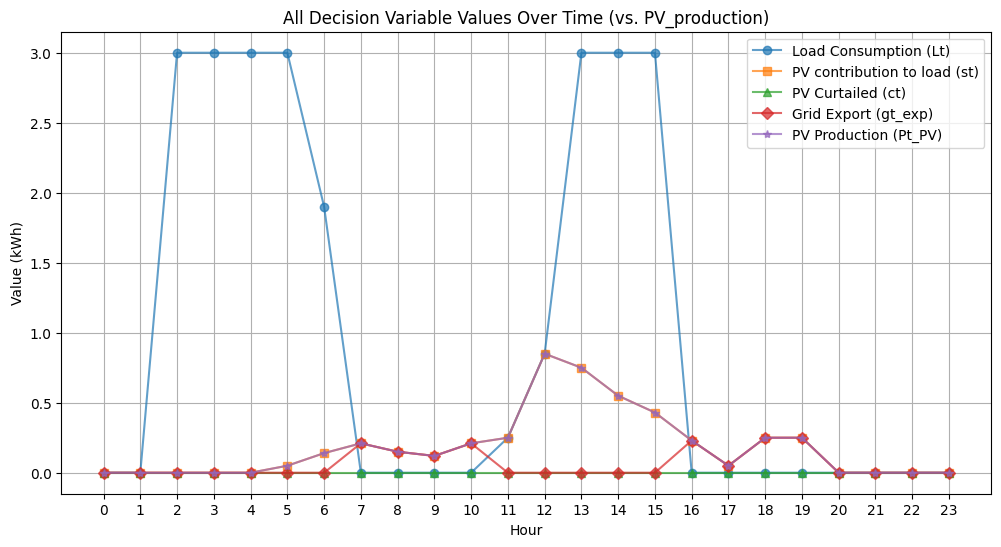

In [ ]:
import matplotlib.pyplot as plt

# Extract variable values from the optimization results
Lt_values = [Lt[t].X for t in HOURS]
st_values = [st[t].X for t in HOURS]
ct_values = [ct[t].X for t in HOURS]
gt_imp_values = [gt_imp[t].X for t in HOURS]
gt_exp_values = [gt_exp[t].X for t in HOURS]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(HOURS, Lt_values, label='Load Consumption (Lt)', alpha=0.7, marker='o')
plt.plot(HOURS, st_values, label='PV not curtailed (st)', alpha=0.7, marker='s')
plt.plot(HOURS, ct_values, label='PV Curtailed (ct)', alpha=0.7, marker='^')
#plt.plot(HOURS, gt_imp_values, label='Grid Import (gt_imp)', alpha=0.7, marker='x')
plt.plot(HOURS, gt_exp_values, label='Grid Export (gt_exp)', alpha=0.7, marker='D')
Pt_PV = der_production[0]["hourly_profile_ratio"]
plt.plot(HOURS, Pt_PV, label='PV Production (Pt_PV)', alpha=0.7, marker='*')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Value (kWh)')
plt.title('All Decision Variable Values Over Time (vs. PV_production)')
plt.xticks(HOURS)
plt.legend()
plt.grid(True)
plt.show()

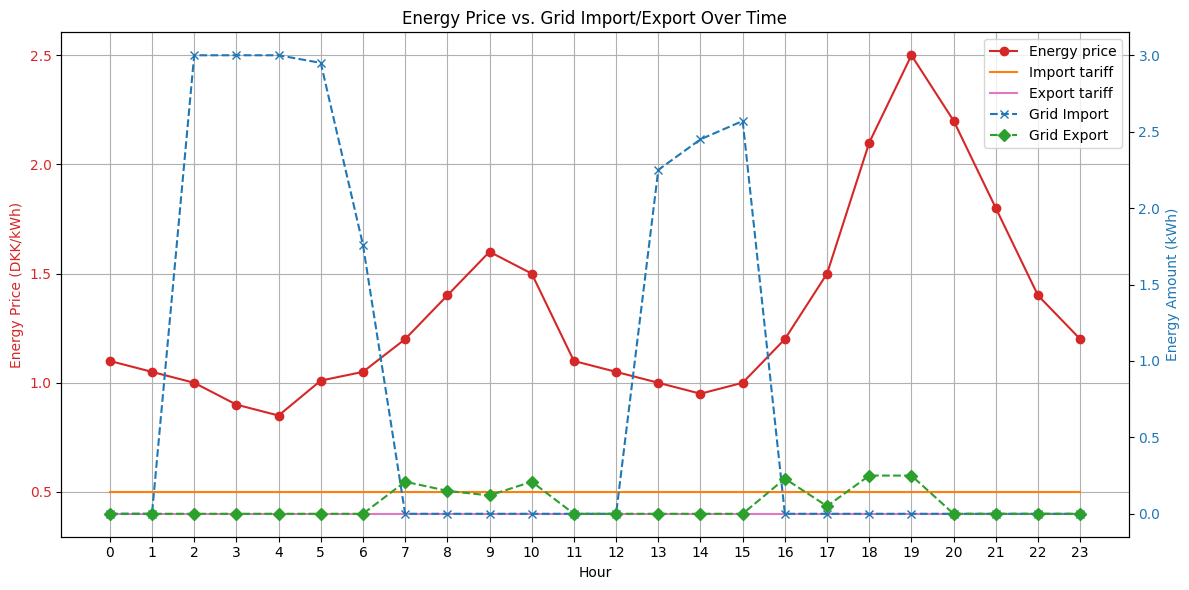

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot energy price on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Hour')
ax1.set_ylabel('Energy Price (DKK/kWh)', color=color)
ax1.plot(HOURS, pt, color=color, marker='o', label='Energy price(DKK/kWh)')
ax1.plot(HOURS, np.repeat(tau_imp, 24), color='tab:orange',  label='Import tariff (DKK/kWh)')
ax1.plot(HOURS, np.repeat(tau_exp, 24), color='tab:pink',  label='Export tariff (DKK/kWh)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis for import/export
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Energy Amount (kWh)', color=color)
ax2.plot(HOURS, gt_imp_values, color='tab:blue', marker='x', linestyle='dashed', label='Grid Import(kWh)')
ax2.plot(HOURS, gt_exp_values, color='tab:green', marker='D', linestyle='dashed', label='Grid Export(kWh)')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title('Energy Price vs. Grid Import/Export Over Time')
fig.tight_layout() # To prevent labels overlapping
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.xticks(HOURS)
plt.show()

# TODO i dont know why KWH axis doesnt start at zero